# Testing the leaf photosynthesis model

In [1]:
# Add PATH (adapt!)
push!(LOAD_PATH, "/Volumes/cfranken/code/gitHub/LSM-SPAM/src/Leaf/");
push!(LOAD_PATH, "/Volumes/cfranken/code/gitHub/LSM-SPAM/src/Utils/");

In [2]:
using Leaf
using MathToolsMod
using LeafPhotosynthesis
using BenchmarkTools
using Plots

In [3]:
pyplot()

Plots.PyPlotBackend()

In [4]:
# Create a leaf structure
l = leaf_params{Float32}();
l2 = leaf_params{Float32}();
# Create a Flux structure
f = LeafPhotosynthesis.fluxes{Float32}();

In [5]:
# initialize some reasonable values
f.je = 100;
f.gbc = 100;
f.gbv = 100;
f.ceair=1500;
f.eair = 1500;
f.APAR = 500;

In [6]:
l.Kn = 2.44
LeafPhotosynthesis.LeafPhotosynthesis(f,l,298.0,f.APAR);

In [31]:
# Test speed 
@benchmark LeafPhotosynthesis.LeafPhotosynthesis(f,l,rand(Float32,1)[1]+300, 1000)

BenchmarkTools.Trial: 
  memory estimate:  5.98 KiB
  allocs estimate:  308
  --------------
  minimum time:     7.882 μs (0.00% GC)
  median time:      8.739 μs (0.00% GC)
  mean time:        9.457 μs (3.61% GC)
  maximum time:     1.236 ms (97.57% GC)
  --------------
  samples:          10000
  evals/sample:     3

### Get some PAR response curves

In [32]:
apar = Float32[]
gpp  = Float32[]
apar_ = Float32[]
gpp_  = Float32[]
f.cair = 400
l.vcmax25 = 90
l.jmax25 = 90*1.9
l2.vcmax25 = 50
l2.jmax25 = 50*1.9
for f.APAR in 0:10:1000
    LeafPhotosynthesis.LeafPhotosynthesis(f,l,298.0,f.APAR);
    push!(apar, f.APAR)
    push!(gpp, f.an)
    LeafPhotosynthesis.LeafPhotosynthesis(f,l2,298.0,f.APAR);
    push!(apar_, f.APAR)
    push!(gpp_, f.an)
    #println(f.APAR, " ", f.ag, " ", f.an)
end

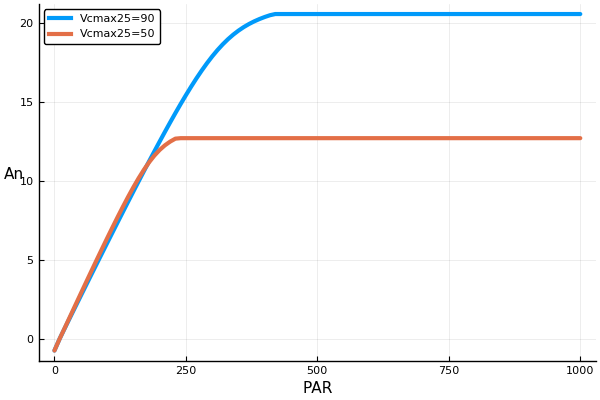

In [33]:
plot(apar, gpp, lw=3, label="Vcmax25=90", ylabel="An", xlabel="PAR")
plot!(apar, gpp_, lw=3, label="Vcmax25=50")


In [34]:
# Test T dependence
T_ = Float32[]
ag_T_  = Float32[]
an_T_  = Float32[]
vcmax_T_  = Float32[]
electron_co2_T_  = Float32[]
gamma_T_  = Float32[]
f.APAR = 500
for T in 260:1:320
    LeafPhotosynthesis.LeafPhotosynthesis(f,l,T,f.APAR);
    push!(T_, T)
    push!(ag_T_, f.ag)
    push!(an_T_, f.an)
    push!(vcmax_T_, l.vcmax)
    push!(electron_co2_T_, l.CO2_per_electron)
    push!(gamma_T_ , l.Γstar)
end

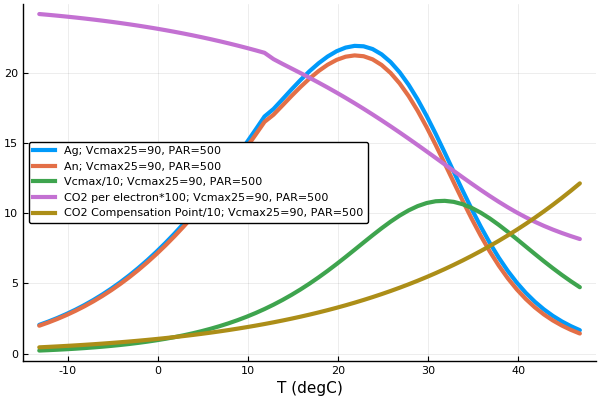

In [35]:
plot(T_.-273.15, ag_T_, lw=3, label="Ag; Vcmax25=90, PAR=500", xlabel="T (degC)")
plot!(T_.-273.15, an_T_, lw=3, label="An; Vcmax25=90, PAR=500")
plot!(T_.-273.15, vcmax_T_/10, lw=3, label="Vcmax/10; Vcmax25=90, PAR=500")
plot!(T_.-273.15, electron_co2_T_*100, lw=3, label="CO2 per electron*100; Vcmax25=90, PAR=500")
plot!(T_.-273.15, gamma_T_/10, lw=3, label="CO2 Compensation Point/10; Vcmax25=90, PAR=500")

# Try a dynamic model here

In [36]:
tmax = 5000 # Time in seconds here
l = leaf_params{Float32}()
l.gstyp=0;
f = LeafPhotosynthesis.fluxes{Float32}()
l.dynamic_state = true
#l.gstyp = 1
f.cair = 400
l.vcmax25 = 90
l.jmax25 = 90*1.9
uu = zeros(tmax,10)
uu[1,2] = 0.07 # Start gs
uu[1,1] = 0.5  # Start Kn
f.APAR = 500
l.rdleaf = 0.0

for c = 2:1:tmax
    l.gs = uu[c-1,2]
    l.Kn = uu[c-1,1]

    uu[c-1,3]=l.ϕs
    uu[c-1,4]=l.Ci
    uu[c-1,5]=f.φ
    uu[c-1,6]=l.Kp
    uu[c-1,8]=f.an
    uu[c-1,9]=l.Fm
    uu[c-1,7]=f.APAR
    #l.Kp = 4
    LeafPhotosynthesis.LeafPhotosynthesis(f,l,298.0,f.APAR)
    uu[c,1] = uu[c-1,1]+(l.Kn_ss-l.Kn)/0.2*1/60
    uu[c,2] = uu[c-1,2]+(l.gs_ss-l.gs)/15*1/60
    #println(l.Kn_ss, " ",  l.Ci, " ", f.φ)
end
t = range(1,tmax,step=1)

1:1:5000

In [41]:
@show f.φ
@show l.ϕs
@show l.CO2_per_electron
@show l.Ci
@show l.Γstar


f.φ = 0.54127884f0
l.ϕs = 0.014637204f0
l.CO2_per_electron = 0.17680421f0
l.Ci = 349.8399f0
l.Γstar = 42.42289f0


42.42289f0

In [39]:

# Compute steady state solution 
l2.vcmax25 = 90
l2.jmax25 = 90*1.9
l2.gstyp=0
l2.dynamic_state=false
LeafPhotosynthesis.LeafPhotosynthesis(f,l2,298.0, f.APAR)

0.71265656f0

In [42]:
println(f.φ)
println(l2.ϕs)
println(l2.CO2_per_electron)
println(l2.Ci)
println(l2.Γstar)

0.54127884
0.014699058
0.17674695
349.5002
42.42289


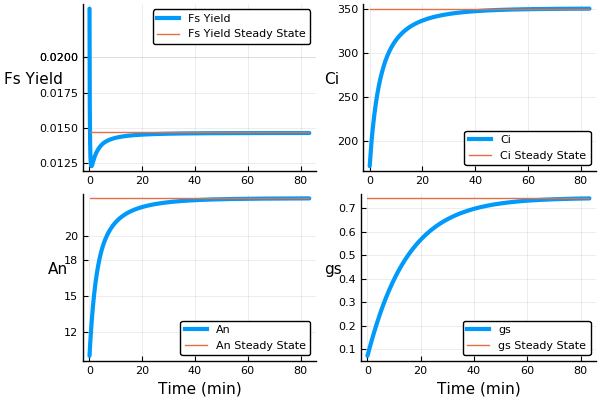

In [43]:
#p1 = plot(t[2:end-1]/60,uu[2:end-1,1],ylabel="Kn",lw=3, label="Kn") # Make a line plot
#p2 = plot(t[2:end-1]/60,uu[2:end-1,6],ylabel="Kp",lw=3, label="Kp") # Make a scatter plot
p3 = plot(t[2:end-1]/60,uu[2:end-1,3],ylabel="Fs Yield",lw=3, label="Fs Yield")
plot!([t[2],t[end-1]]/60,[l2.ϕs,l2.ϕs ],label="Fs Yield Steady State" )
p4 = plot(t[2:end-1]/60,uu[2:end-1,4],ylabel="Ci",lw=3, label="Ci")
plot!([t[2],t[end-1]]/60,[l2.Ci,l2.Ci ],label="Ci Steady State" )
#p5 = plot(t[2:end-1]/60,uu[2:end-1,7],ylabel="PAR",lw=3, label="PAR")# Four histograms each with 10 points? Why not!
p6 = plot(t[2:end-1]/60,uu[2:end-1,8],ylabel="An",lw=3, label="An", xlabel="Time (min)")# Four histograms each with 10 points? Why not!
plot!([t[2],t[end-1]]/60,[f.an,f.an ],label="An Steady State" )
p7 = plot(t[2:end-1]/60,uu[2:end-1,2],ylabel="gs",lw=3, label="gs", xlabel="Time (min)")
plot!([t[2],t[end-1]]/60,[l.gs,l.gs ],label="gs Steady State" )
#p8 = plot(t[2:end-1]/60,uu[2:end-1,5],ylabel="PSII yield",lw=3, label="PSII yield")

plot(p3,p4,p6,p7,layout=(2,2))

In [44]:
using DelimitedFiles
PAR  = readdlm("/Users/cfranken/PAR.dat");
length(PAR)

172422

In [46]:
tmax = length(PAR) # Time in seconds here
t = range(1,tmax,step=1)
l = leaf_params{Float32}()
f = LeafPhotosynthesis.fluxes{Float32}()
l.dynamic_state = true
l.gstyp = 0
l.g1=4
f.cair = 400
l.vcmax25 = 90
l.jmax25 = 90*1.9
uu = zeros(tmax,10)
uu[1,2] = 0.07
uu[1,1] = 0.5
f.APAR = 50
l.rdleaf = 0.0

#apar[1:500]=0
#apar[501:100]=0
for c = 2:1:tmax
    #println(apar[c])
    f.APAR = PAR[c]*0.5 
    f.APAR = max(10,f.APAR)
    
       l.gs = uu[c-1,2]
       l.Kn = uu[c-1,1]

       uu[c-1,3]=l.ϕs
       uu[c-1,4]=l.Ci
       uu[c-1,5]=f.φ
       uu[c-1,6]=l.Kp
       uu[c-1,8]=f.an
       uu[c-1,9]=l.Fm′
       uu[c-1,7]=f.APAR
       #l.Kp = 4
       LeafPhotosynthesis.LeafPhotosynthesis(f,l,298.0,f.APAR)
    if (l.Kn_ss-l.Kn) > 0
        tau_k = 1
    else
        tau_k = 1
    end
       uu[c,1] = uu[c-1,1]+(l.Kn_ss-l.Kn)/tau_k*1/60
       uu[c,2] = uu[c-1,2]+(l.gs_ss-l.gs)/20*1/60
    #println(l.Kn_ss, " ",  l.Ci, " ", f.φ, " ", l.gs_ss, " ", f.APAR)
end

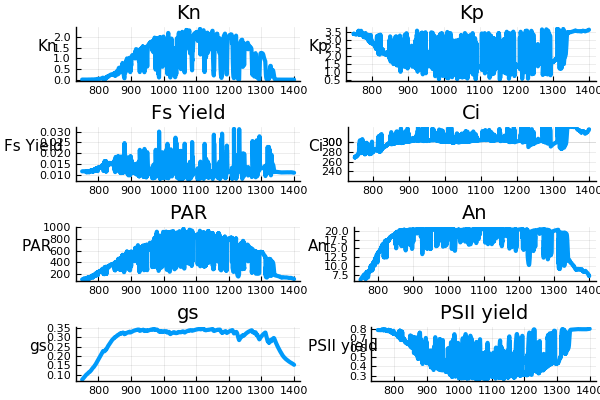

In [47]:
step = 10
xl = (60*750,60*1400)
ranger = xl[1]:step:xl[2]

p1 = plot(t[ranger]/60,uu[ranger,1],ylabel="Kn",lw=3, title="Kn", legend=false) # Make a line plot
p2 = plot(t[ranger]/60,uu[ranger,6],ylabel="Kp",lw=3, title="Kp", legend=false) # Make a scatter plot
p3 = plot(t[ranger]/60,uu[ranger,3],ylabel="Fs Yield",lw=3, title="Fs Yield", legend=false)
p4 = plot(t[ranger]/60,uu[ranger,4],ylabel="Ci",lw=3, title="Ci", legend=false,  ylim=(220,330))
p5 = plot(t[ranger]/60,uu[ranger,7],ylabel="PAR",lw=3, title="PAR", legend=false)# Four histograms each with 10 points? Why not!
p6 = plot(t[ranger]/60,uu[ranger,8],ylabel="An",lw=3, title="An", legend=false)# Four histograms each with 10 points? Why not!
p7 = plot(t[ranger]/60,uu[ranger,2],ylabel="gs'",lw=3, title="gs", legend=false)
p8 = plot(t[ranger]/60,uu[ranger,5],ylabel="PSII yield",lw=3, title="PSII yield", legend=false)

plot(p1,p2,p3,p4,p5,p6,p7,p8,layout=(4,2))

In [48]:
tmax = length(PAR) # Time in seconds here
t = range(1,tmax,step=1)
l = leaf_params{Float32}()
f = LeafPhotosynthesis.fluxes{Float32}()
l.dynamic_state = false
l.g1=4
l.gstyp = 0
f.cair = 400
l.vcmax25 = 90
l.jmax25 = 90*1.9
uus = zeros(tmax,10)
uus[1,2] = 0.07
uus[1,1] = 0.5
f.APAR = 50
l.rdleaf = 0.0

#apar[1:500]=0
#apar[501:100]=0
for c = 2:1:tmax
    #println(apar[c])
    f.APAR = PAR[c]*0.5 
    f.APAR = max(10,f.APAR)
    LeafPhotosynthesis.LeafPhotosynthesis(f,l,298.0,f.APAR)
    uus[c,2]=l.gs
    uus[c,1]=l.Kn_ss

    uus[c,3]=l.ϕs
    uus[c,4]=l.Ci
    uus[c,5]=f.φ
    uus[c,6]=l.Kp
    uus[c,8]=f.an
    uus[c,9]=l.Fm′
    uus[c,7]=f.APAR
    
end

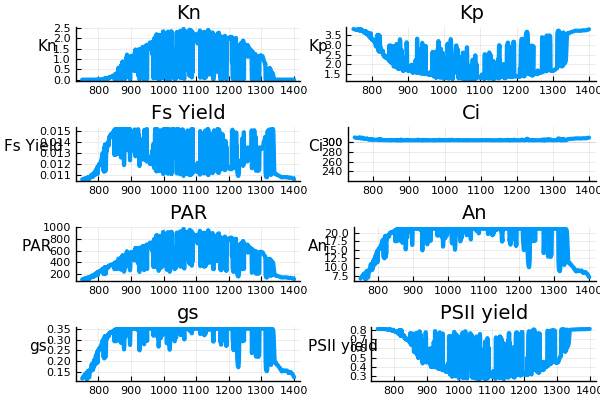

In [49]:
step = 30
xl = (60*750,60*1400)
ranger = xl[1]:step:xl[2]
 
p1 = plot(t[ranger]/60,uus[ranger,1],ylabel="Kn",lw=3, title="Kn", legend=false) # Make a line plot
p2 = plot(t[ranger]/60,uus[ranger,6],ylabel="Kp",lw=3, title="Kp", legend=false) # Make a scatter plot
p3 = plot(t[ranger]/60,uus[ranger,3],ylabel="Fs Yield",lw=3, title="Fs Yield", legend=false)
p4 = plot(t[ranger]/60,uus[ranger,4],ylabel="Ci",lw=3, title="Ci", legend=false,  ylim=(220,330))
p5 = plot(t[ranger]/60,uus[ranger,7],ylabel="PAR",lw=3, title="PAR", legend=false)# Four histograms each with 10 points? Why not!
p6 = plot(t[ranger]/60,uus[ranger,8],ylabel="An",lw=3, title="An", legend=false)# Four histograms each with 10 points? Why not!
p7 = plot(t[ranger]/60,uus[ranger,2],ylabel="gs'",lw=3, title="gs", legend=false)
p8 = plot(t[ranger]/60,uus[ranger,5],ylabel="PSII yield",lw=3, title="PSII yield", legend=false)
 
plot(p1,p2,p3,p4,p5,p6,p7,p8,layout=(4,2))
 

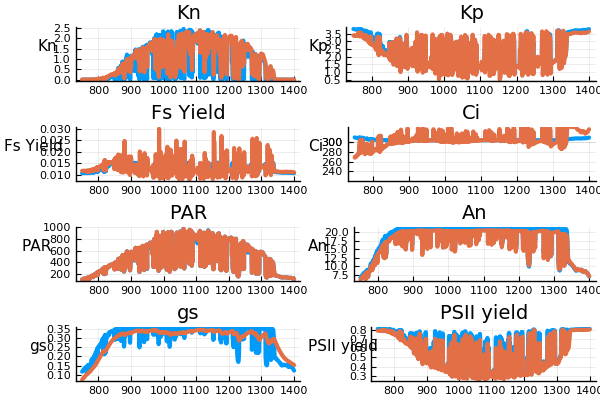

In [50]:
step = 30
xl = (60*750,60*1400)
ranger = xl[1]:step:xl[2]
 
p1 = plot(t[ranger]/60,uus[ranger,1],ylabel="Kn",lw=3, title="Kn", legend=false) # Make a line plot
p1 = plot!(t[ranger]/60,uu[ranger,1],ylabel="Kn",lw=3, title="Kn", legend=false) # Make a line plot
 
 
p2 = plot(t[ranger]/60,uus[ranger,6],ylabel="Kp",lw=3, title="Kp", legend=false) # Make a scatter plot
p2 = plot!(t[ranger]/60,uu[ranger,6],ylabel="Kp",lw=3, title="Kp", legend=false) # Make a scatter plot
 
 
p3 = plot(t[ranger]/60,uus[ranger,3],ylabel="Fs Yield",lw=3, title="Fs Yield", legend=false)
p3 = plot!(t[ranger]/60,uu[ranger,3],ylabel="Fs Yield",lw=3, title="Fs Yield", legend=false)
 
 
p4 = plot(t[ranger]/60,uus[ranger,4],ylabel="Ci",lw=3, title="Ci", legend=false,  ylim=(220,330))
p4 = plot!(t[ranger]/60,uu[ranger,4],ylabel="Ci",lw=3, title="Ci", legend=false,  ylim=(220,330))
#
p5 = plot(t[ranger]/60,uus[ranger,7],ylabel="PAR",lw=3, title="PAR", legend=false)# Four histograms each with 10 points? Why not!
p5 = plot!(t[ranger]/60,uu[ranger,7],ylabel="PAR",lw=3, title="PAR", legend=false)# Four histograms each with 10 points? Why not!
#
p6 = plot(t[ranger]/60,uus[ranger,8],ylabel="An",lw=3, title="An", legend=false)# Four histograms each with 10 points? Why not!
p6 = plot!(t[ranger]/60,uu[ranger,8],ylabel="An",lw=3, title="An", legend=false)# Four histograms each with 10 points? Why not!
#
p7 = plot(t[ranger]/60,uus[ranger,2],ylabel="gs'",lw=3, title="gs", legend=false)
p7 = plot!(t[ranger]/60,uu[ranger,2],ylabel="gs'",lw=3, title="gs", legend=false)
#
p8 = plot(t[ranger]/60,uus[ranger,5],ylabel="PSII yield",lw=3, title="PSII yield", legend=false)
p8 = plot!(t[ranger]/60,uu[ranger,5],ylabel="PSII yield",lw=3, title="PSII yield", legend=false)
 
 
#p2 = plot(t[ranger]/60,uu[ranger,6],ylabel="Kp",lw=3, title="Kp", legend=false) # Make a scatter plot
#p3 = plot(t[ranger]/60,uu[ranger,3],ylabel="Fs Yield",lw=3, title="Fs Yield", legend=false)
#p4 = plot(t[ranger]/60,uu[ranger,4],ylabel="Ci",lw=3, title="Ci", legend=false,  ylim=(220,330))
#p5 = plot(t[ranger]/60,uu[ranger,7],ylabel="PAR",lw=3, title="PAR", legend=false)# Four histograms each with 10 points? Why not!
#p6 = plot(t[ranger]/60,uu[ranger,8],ylabel="An",lw=3, title="An", legend=false)# Four histograms each with 10 points? Why not!
#p7 = plot(t[ranger]/60,uu[ranger,2],ylabel="gs'",lw=3, title="gs", legend=false)
#p8 = plot(t[ranger]/60,uu[ranger,5],ylabel="PSII yield",lw=3, title="PSII yield", legend=false)
 
 
plot(p1,p2,p3,p4,p5,p6,p7,p8,layout=(4,2))

In [52]:
tmax = 6100 # Time in seconds here
t = range(1,tmax,step=1)
l = leaf_params{Float32}()
f = LeafPhotosynthesis.fluxes{Float32}()
l.dynamic_state = true
#l.gstyp = 1
f.cair = 400
l.vcmax25 = 90
l.jmax25 = 90*1.9
uu = zeros(tmax,10)
uu[1,2] = 0.07
uu[1,1] = 0.5
f.APAR = 50
l.rdleaf = 0.0
apar = zeros(tmax)
apar[:].=100
for i in 1:8
    #println(i," ", (i-1)*500+1, " ", (i)*500, " ", i*100 )
    apar[(i-1)*500+1:(i)*500].=i*150
end
for i in 9:12
    println(i," ", (i-1)*500+1, " ", (i)*500, " ", 1500-(i-9)*500 )
    apar[(i-1)*500+1:(i)*500].=1500-(i-9)*700
end
#apar[1:500]=0
#apar[501:100]=0
for c = 2:1:tmax
    #println(apar[c])
    f.APAR = apar[c] 
    
       l.gs = uu[c-1,2]
       l.Kn = uu[c-1,1]

       uu[c-1,3]=l.ϕs
       uu[c-1,4]=l.Ci
       uu[c-1,5]=f.φ
       uu[c-1,6]=l.Kp
       uu[c-1,8]=f.an
       uu[c-1,9]=l.Fm′
       uu[c-1,7]=f.APAR
       #l.Kp = 4
       LeafPhotosynthesis.LeafPhotosynthesis(f,l,298.0,f.APAR)
    if (l.Kn_ss-l.Kn) > 0
        tau_k = 0.1
    else
        tau_k = 1
    end
       uu[c,1] = uu[c-1,1]+(l.Kn_ss-l.Kn)/tau_k*1/60
       uu[c,2] = uu[c-1,2]+(l.gs_ss-l.gs)/20*1/60
       #println(l.Kn_ss, " ",  l.Ci, " ", f.φ)
end

9 4001 4500 1500
10 4501 5000 1000
11 5001 5500 500
12 5501 6000 0


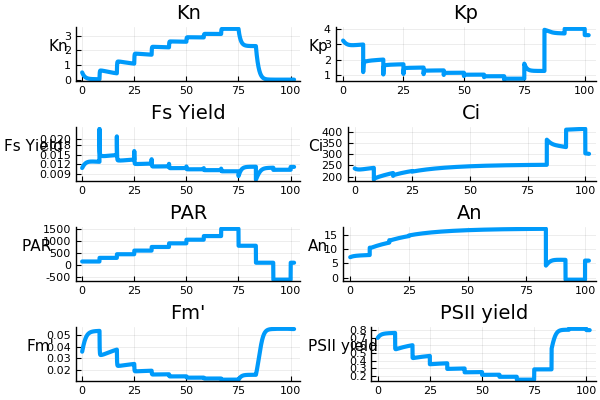

In [53]:
p1 = plot(t[2:end-1]/60,uu[2:end-1,1],ylabel="Kn",lw=3, title="Kn", legend=false) # Make a line plot
p2 = plot(t[2:end-1]/60,uu[2:end-1,6],ylabel="Kp",lw=3, title="Kp", legend=false) # Make a scatter plot
p3 = plot(t[2:end-1]/60,uu[2:end-1,3],ylabel="Fs Yield",lw=3, title="Fs Yield", legend=false)
p4 = plot(t[2:end-1]/60,uu[2:end-1,4],ylabel="Ci",lw=3, title="Ci", legend=false)
p5 = plot(t[2:end-1]/60,uu[2:end-1,7],ylabel="PAR",lw=3, title="PAR", legend=false)# Four histograms each with 10 points? Why not!
p6 = plot(t[2:end-1]/60,uu[2:end-1,8],ylabel="An",lw=3, title="An", legend=false)# Four histograms each with 10 points? Why not!
p7 = plot(t[2:end-1]/60,uu[2:end-1,9],ylabel="Fm'",lw=3, title="Fm'", legend=false)
p8 = plot(t[2:end-1]/60,uu[2:end-1,5],ylabel="PSII yield",lw=3, title="PSII yield", legend=false)

plot(p1,p2,p3,p4,p5,p6,p7,p8,layout=(4,2))

In [54]:
using Statistics
PAR2 = PAR;
# 10 minutes
wind = 60*10

for i in 1:length(PAR2)
    
    mini = max(1,i-wind)
    maxi = min(length(PAR2),i+wind)
    PAR2[i] = mean(PAR[mini:maxi])
end


In [55]:
tmax = length(PAR) # Time in seconds here
t = range(1,tmax,step=1)
l = leaf_params{Float32}()
f = LeafPhotosynthesis.fluxes{Float32}()
l.dynamic_state = true
l.gstyp = 0
l.g1=3.5
f.cair = 400
l.vcmax25 = 90
l.jmax25 = 90*1.9
uu = zeros(tmax,10)
uu[1,2] = 0.07
uu[1,1] = 0.5
f.APAR = 50
l.rdleaf = 0.0

#apar[1:500]=0
#apar[501:100]=0
for c = 2:1:tmax
    #println(apar[c])
    f.APAR = PAR2[c]*0.5 
    f.APAR = max(10,f.APAR)
    
       l.gs = uu[c-1,2]
       l.Kn = uu[c-1,1]

       uu[c-1,3]=l.ϕs
       uu[c-1,4]=l.Ci
       uu[c-1,5]=f.φ
       uu[c-1,6]=l.Kp
       uu[c-1,8]=f.an
       uu[c-1,9]=l.Fm′
       uu[c-1,7]=f.APAR
       #l.Kp = 4
       LeafPhotosynthesis.LeafPhotosynthesis(f,l,298.0,f.APAR)
    if (l.Kn_ss-l.Kn) > 0
        tau_k = 1
    else
        tau_k = 1
    end
       uu[c,1] = uu[c-1,1]+(l.Kn_ss-l.Kn)/tau_k*1/60
       uu[c,2] = uu[c-1,2]+(l.gs_ss-l.gs)/20*1/60
    #println(l.Kn_ss, " ",  l.Ci, " ", f.φ, " ", l.gs_ss, " ", f.APAR)
end

In [56]:
tmax = length(PAR) # Time in seconds here
t = range(1,tmax,step=1)
l = leaf_params{Float32}()
f = LeafPhotosynthesis.fluxes{Float32}()
l.dynamic_state = false
l.g1=3.5
l.gstyp = 0
f.cair = 400
l.vcmax25 = 90
l.jmax25 = 90*1.9
uus = zeros(tmax,10)
uus[1,2] = 0.07
uus[1,1] = 0.5
f.APAR = 50
l.rdleaf = 0.0

#apar[1:500]=0
#apar[501:100]=0
for c = 2:1:tmax
    #println(apar[c])
    f.APAR = PAR2[c]*0.5 
    f.APAR = max(10,f.APAR)
    LeafPhotosynthesis.LeafPhotosynthesis(f,l,298.0,f.APAR )
    uus[c,2]=l.gs
    uus[c,1]=l.Kn_ss

    uus[c,3]=l.ϕs
    uus[c,4]=l.Ci
    uus[c,5]=f.φ
    uus[c,6]=l.Kp
    uus[c,8]=f.an
    uus[c,9]=l.Fm′
    uus[c,7]=f.APAR
    
end

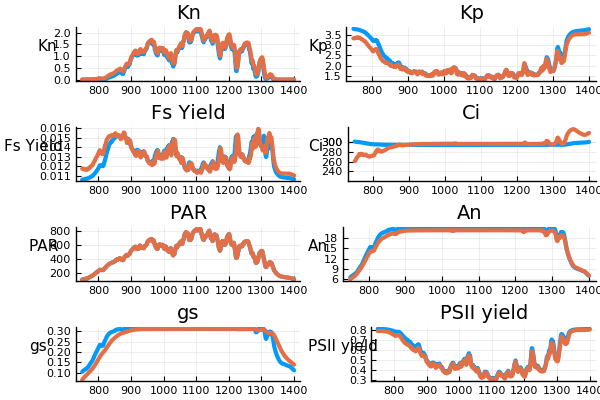

In [57]:
step = 30
xl = (60*750,60*1400)
ranger = xl[1]:step:xl[2]
 
p1 = plot(t[ranger]/60,uus[ranger,1],ylabel="Kn",lw=3, title="Kn", legend=false) # Make a line plot
p1 = plot!(t[ranger]/60,uu[ranger,1],ylabel="Kn",lw=3, title="Kn", legend=false) # Make a line plot
 
 
p2 = plot(t[ranger]/60,uus[ranger,6],ylabel="Kp",lw=3, title="Kp", legend=false) # Make a scatter plot
p2 = plot!(t[ranger]/60,uu[ranger,6],ylabel="Kp",lw=3, title="Kp", legend=false) # Make a scatter plot
 
 
p3 = plot(t[ranger]/60,uus[ranger,3],ylabel="Fs Yield",lw=3, title="Fs Yield", legend=false)
p3 = plot!(t[ranger]/60,uu[ranger,3],ylabel="Fs Yield",lw=3, title="Fs Yield", legend=false)
 
 
p4 = plot(t[ranger]/60,uus[ranger,4],ylabel="Ci",lw=3, title="Ci", legend=false,  ylim=(220,330))
p4 = plot!(t[ranger]/60,uu[ranger,4],ylabel="Ci",lw=3, title="Ci", legend=false,  ylim=(220,330))
#
p5 = plot(t[ranger]/60,uus[ranger,7],ylabel="PAR",lw=3, title="PAR", legend=false)# Four histograms each with 10 points? Why not!
p5 = plot!(t[ranger]/60,uu[ranger,7],ylabel="PAR",lw=3, title="PAR", legend=false)# Four histograms each with 10 points? Why not!
#
p6 = plot(t[ranger]/60,uus[ranger,8],ylabel="An",lw=3, title="An", legend=false)# Four histograms each with 10 points? Why not!
p6 = plot!(t[ranger]/60,uu[ranger,8],ylabel="An",lw=3, title="An", legend=false)# Four histograms each with 10 points? Why not!
#
p7 = plot(t[ranger]/60,uus[ranger,2],ylabel="gs'",lw=3, title="gs", legend=false)
p7 = plot!(t[ranger]/60,uu[ranger,2],ylabel="gs'",lw=3, title="gs", legend=false)
#
p8 = plot(t[ranger]/60,uus[ranger,5],ylabel="PSII yield",lw=3, title="PSII yield", legend=false)
p8 = plot!(t[ranger]/60,uu[ranger,5],ylabel="PSII yield",lw=3, title="PSII yield", legend=false)
 
 
#p2 = plot(t[ranger]/60,uu[ranger,6],ylabel="Kp",lw=3, title="Kp", legend=false) # Make a scatter plot
#p3 = plot(t[ranger]/60,uu[ranger,3],ylabel="Fs Yield",lw=3, title="Fs Yield", legend=false)
#p4 = plot(t[ranger]/60,uu[ranger,4],ylabel="Ci",lw=3, title="Ci", legend=false,  ylim=(220,330))
#p5 = plot(t[ranger]/60,uu[ranger,7],ylabel="PAR",lw=3, title="PAR", legend=false)# Four histograms each with 10 points? Why not!
#p6 = plot(t[ranger]/60,uu[ranger,8],ylabel="An",lw=3, title="An", legend=false)# Four histograms each with 10 points? Why not!
#p7 = plot(t[ranger]/60,uu[ranger,2],ylabel="gs'",lw=3, title="gs", legend=false)
#p8 = plot(t[ranger]/60,uu[ranger,5],ylabel="PSII yield",lw=3, title="PSII yield", legend=false)
 
 
plot(p1,p2,p3,p4,p5,p6,p7,p8,layout=(4,2))